# Diet Classification - Part 3

Part 3 consist of the preprocessing and modelling of the combined datasets. Data extraction and EDA will be available in Part 1 and Part 2 respectively.

## Content

## Data Import

In [366]:
#import vanilla python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import preprocessing library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [79]:
#Import combine datasets
combined = pd.read_csv('../data/combined_df')
#set max row preview
pd.set_option('display.max_column', 1000)

In [80]:
combined.head()

,author,link_flair_text,num_comments,subreddit_subscribers,subreddit,text,post_datetime,date,hour,day,text_word_count
0,Elise_93,Funny,0,590954,vegan,A summary of carnist logic about PETA:,2021-04-18 02:03:10,2021-04-18,2,18,7
1,SeviathanVonEldritch,Rant,0,590952,vegan,Underestimated it as well...,2021-04-18 01:57:56,2021-04-18,1,18,4
2,quidiuris,Uncategorised,0,590952,vegan,Hair conditioner bars - any recommendations?,2021-04-18 01:55:05,2021-04-18,1,18,6
3,lunanabiki,Uncategorised,0,590953,vegan,nonvegan logic that surprises me (that i haven...,2021-04-18 01:51:11,2021-04-18,1,18,12
4,pastelprincess1,Uncategorised,0,590953,vegan,Sustainable + Ethical Alternatives Directory,2021-04-18 01:50:06,2021-04-18,1,18,5


In [81]:
#checking to ensure no null value
combined.isna().sum()

author                   0
link_flair_text          0
num_comments             0
subreddit_subscribers    0
subreddit                0
text                     0
post_datetime            0
date                     0
hour                     0
day                      0
text_word_count          0
dtype: int64

## Preprocessing and Modelling

In the preprocessing, we will start with dissecting the text table to remove special characters, like emojis, and digits which will not be critical to the this context. The words will also be filtered on the stop words before modelling.

### Removing special characters and text processing

In [82]:
#import tokenization library

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re

In [321]:
#define tokenizer
def clean_text(words):
    """input for words/text in string to remove special characters"""
    #lowercase words
    words = words.lower()
    
    #remove other words/digit/special character
    tokenizer = RegexpTokenizer(r'[a-z]+')
    words = tokenizer.tokenize(words)
    
    #stem/lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    #remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [ ]:
cleaned_text  = combined['text'].apply(clean_text)
#add col for cleaned text
combined['cleaned_text'] = cleaned_text
combined.head()

In [87]:
combined.to_csv('../data/model_data.csv',index=False)

### Model Definition 

Naives Bayes and Logistic Regression model will be employed for this classification model. These results will be processed through CountVectoriser and TfidfVectoriser to observed the best model pairing of prediction. 

### Baseline Model

In [325]:
#define X and y 

X = combined['cleaned_text']
y = combined['subreddit']

In [326]:
#check proportion of both reddits
y.value_counts(normalize = True)

keto     0.507541
vegan    0.492459
Name: subreddit, dtype: float64

In [327]:
print(f'Baseline Accuracy: {round(y.value_counts(normalize = True),3).values.max()}')

Baseline Accuracy: 0.508


In [328]:
#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size= 0.33, 
                                                    random_state=42)

### Logistic Regression

#### Count Vectorization

In [329]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipe_params = {
    'cvec__max_features': [8000, 8500],
    'cvec__max_df': [0.8, 0.85],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 0.1]
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_lr_cvec = gs.best_estimator_
print('Training Accuracy: ', best_lr_cvec.score(X_train, y_train))
print('Testing Accuracy: ', best_lr_cvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9706721623335447
Testing Accuracy:  0.929835854522047




{'cvec__max_df': 0.8,
 'cvec__max_features': 8000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__C': 1,
 'lr__penalty': 'l2'}

#### Tfidf Vectorization

In [330]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipe_params = {
    'tvec__max_features': [8500, 9000],
    'tvec__max_df': [0.7, 0.8],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 0.1]
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_lr_tvec = gs.best_estimator_
print('Training Accuracy: ', best_lr_tvec.score(X_train, y_train))
print('Testing Accuracy: ', best_lr_tvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9580691185795814
Testing Accuracy:  0.9356292243321532




{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.7,
 'tvec__max_features': 8500,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

### Naive Bayes

#### Count Vectorization

In [331]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [8000, 9000],
    'cvec__max_df': [0.3, 0.4],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0, 1)
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_nb_cvec = gs.best_estimator_
print('Training Accuracy: ', best_nb_cvec.score(X_train, y_train))
print('Testing Accuracy: ', best_nb_cvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9300887761572606
Testing Accuracy:  0.9124557450917283




{'cvec__max_df': 0.4,
 'cvec__max_features': 9000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.1020408163265306}

#### Tfidf Vectorization

In [334]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [8000, 8500],
    'tvec__max_df': [0.4, 0.5],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0, 1)
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_nb_tvec = gs.best_estimator_
print('Training Accuracy: ', best_nb_tvec.score(X_train, y_train))
print('Testing Accuracy: ', best_nb_tvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.937856689917565
Testing Accuracy:  0.9110074026392018




{'nb__alpha': 0.02040816326530612,
 'tvec__max_df': 0.4,
 'tvec__max_features': 8500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [339]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Logistic Regression','Logistic Regression','Naives Bayes','Naives Bayes'],
    'Vectorizer' :['CountVectorizer','TfidfVectorizer','CountVectorizer','TfidfVectorizer'],
    'Training Accuracy' : [best_lr_cvec.score(X_train, y_train), best_lr_tvec.score(X_train, y_train), 
                           best_nb_cvec.score(X_train, y_train), best_nb_tvec.score(X_train, y_train)],
    'Test Accuracy' : [best_lr_cvec.score(X_test, y_test), best_lr_tvec.score(X_test, y_test), 
                       best_nb_cvec.score(X_test, y_test), best_nb_tvec.score(X_test, y_test)]
})

model_df

,Model,Vectorizer,Training Accuracy,Test Accuracy
0,Logistic Regression,CountVectorizer,0.970672,0.929836
1,Logistic Regression,TfidfVectorizer,0.958069,0.935629
2,Naives Bayes,CountVectorizer,0.930089,0.912456
3,Naives Bayes,TfidfVectorizer,0.937857,0.911007


### Model Selection

In [344]:
# prediction to actual
final_model = best_lr_tvec
final_model.fit(X_train,y_train)
preds = final_model.predict(X_test)

In [353]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': preds})

pred_df.head()

,true_values,pred_probs
10516,keto,keto
12713,keto,vegan
16721,keto,keto
11551,keto,keto
10529,keto,keto
6083,vegan,vegan
8433,vegan,vegan
8933,vegan,vegan
13754,keto,keto
14253,keto,keto


In [358]:
#create col for predicton analysis
pred_res['Success'] = np.where(pred_res['prediction'] == pred_res['actual'],1,0)

#missclassification on fp and fn
miss_vegan = pred_res[(pred_res.Success == 0) & (pred_res.prediction == 'vegan')]
miss_keto = pred_res[(pred_res.Success == 0)  & (pred_res.prediction == 'keto')]

#predict vegan, actual keto
pd.DataFrame(X_test[miss_vegan.index])

,cleaned_text
12997,think tri souffl egg thi morn
11968,waffl iron idea
14787,trucker invertershello ani trucker recommend i...
11641,mood swing
13997,love catastroph consequ cheat
...,...
9672,movi timebett popcorn celeri carrot dairi free...
11267,babi miracl sleep
17113,thought
15412,extraordinari bite bread


In [317]:
#predict keto, actual vegan
pd.DataFrame(X_test[miss_keto.index])

,cleaned_text
3258,fat burning chocolate avocado pudding make minute
8105,first week veganso finally changed diet slowly...
684,make test result triglyceride mg dl cholestero...
2876,rue de perle wine
8647,need new meal eat time day everyday
...,...
3719,started day challenge meal inspo
1340,shelf stable coffee creamer based coconut milk...
1717,think much bread wa today doe anyone keto
4092,zhou spirulina longevity super food review amp...


### Confusion Matrix

In [359]:
cm = confusion_matrix(y_test, preds)

In [360]:
tn,fp,fn,tp = confusion_matrix(y_test, preds).ravel()

In [361]:
print(f'True Negatives: {tn}') #predict keto is keto
print(f'False Positives: {fp}') #predict vegan but keto
print(f'False Negatives: {fn}') #predict keto but vegan
print(f'True Positives: {tp}') #predict vegan is vegan

True Negatives: 2831
False Positives: 323
False Negatives: 77
True Positives: 2983


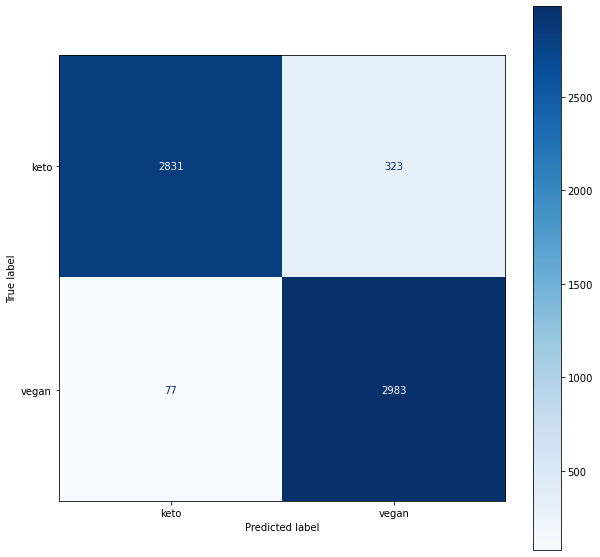

In [378]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(final_model, X_test, y_test, cmap='Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.show()


*Interpretation: High false positive counts compared to false negative.*

### ROC AUC

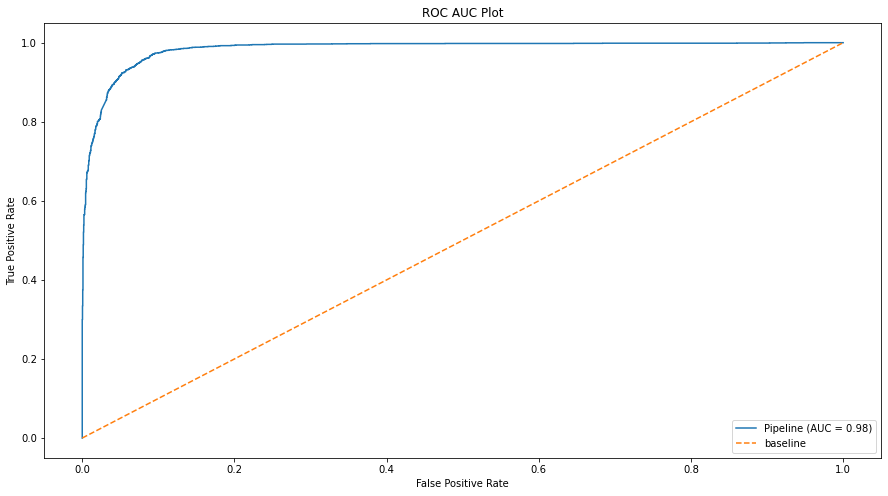

In [382]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_roc_curve(final_model, X_test, y_test, ax=ax)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.title('ROC AUC Plot')
plt.legend()
plt.show()

### Word Importance

In [383]:
coef = best_lr_tvec.named_steps['lr'].coef_
feature_names = best_lr_tvec.named_steps['tvec'].get_feature_names()
word_importance = pd.Series(coef[0], feature_names).sort_values()

In [384]:
#keto
word_importance.head(20)

keto         -16.090898
carb          -7.498172
start         -4.353061
ketosi        -4.261630
weight        -4.198834
fat           -4.008643
keton         -3.641130
lb            -3.552961
pound         -3.260035
week          -3.051808
nsv           -2.996766
sugar         -2.993026
cheat         -2.966863
fast          -2.719138
macro         -2.700996
loss          -2.646992
ketogen       -2.612804
day           -2.591592
lost          -2.508440
electrolyt    -2.490443
dtype: float64

In [385]:
#vegan
word_importance.tail(20)

yummi          1.538793
ban            1.540183
steak          1.553949
soy            1.572888
vegetarian     1.591618
farm           1.659998
ethic          1.680040
pig            1.782741
poll           1.789251
seitan         1.870832
human          2.041641
dairi          2.166729
milk           2.226061
base           2.237990
cow            2.283970
tofu           2.895060
meat           3.348006
plant          3.883008
anim           5.809236
vegan         14.141978
dtype: float64


**Preprocessing and Modeling**
- Is text data successfully converted to a matrix representation?
- Are methods such as stop words, stemming, and lemmatization explored?
- Does the student properly split and/or sample the data for validation/training purposes?
- Does the student test and evaluate a variety of models to identify a production algorithm (**AT MINIMUM:** Bayes and one other model)?
- Does the student defend their choice of production model relevant to the data at hand and the problem?
- Does the student explain how the model works and evaluate its performance successes/downfalls?


**Evaluation and Conceptual Understanding**
- Does the student accurately identify and explain the baseline score?
- Does the student select and use metrics relevant to the problem objective?
- Does the student interpret the results of their model for purposes of inference?
- Is domain knowledge demonstrated when interpreting results?
- Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?


**Conclusion and Recommendations**
- Does the student provide appropriate context to connect individual steps back to the overall project?
- Is it clear how the final recommendations were reached?
- Are the conclusions/recommendations clearly stated?
- Does the conclusion answer the original problem statement?
- Does the student address how findings of this research can be applied for the benefit of stakeholders?
- Are future steps to move the project forward identified?